# Questions

1. How do we tackle differently-sized images?
* If we clip them down, we lose the bounding boxes and target taxon.
* If we standardize them by padding them, would we inadvertently train the model on the padding instead of the image?

# Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import json
import re

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fathomnet-2025/dataset_test.json
/kaggle/input/fathomnet-2025/requirements.txt
/kaggle/input/fathomnet-2025/download.py
/kaggle/input/fathomnet-2025/dataset_train.json


# Import model

In [2]:
#taken from this starter notebook: https://www.kaggle.com/code/picekl/fungiclef25-starter-notebook
!pip install -q git+https://github.com/mlfoundations/open_clip.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00


In [3]:
import open_clip

model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip')
tokenizer = open_clip.get_tokenizer('hf-hub:imageomics/bioclip')

open_clip_pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/469 [00:00<?, ?B/s]

In [4]:
model

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [5]:
tokenizer

# Explore train data

Load and inspect the JSON structure of the train set: 

1. Check whether it's a list or a dictionary
2. If it's a list, check the number of items and the first item
3. If it's a dictionary, check the keys and the values for the first key

In [6]:
with open('/kaggle/input/fathomnet-2025/dataset_train.json', 'r') as f:
    train_data = json.load(f)

print(type(train_data))  
if isinstance(train_data, list):
    print(len(train_data))  
    print(train_data[0])  
elif isinstance(train_data, dict):
    print(train_data.keys())  
    print(train_data[list(train_data.keys())[0]])

<class 'dict'>
dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])
{'year': 2025, 'version': '0', 'description': 'Generated by FathomNet', 'contributor': 'FathomNet', 'url': 'https://database.fathomnet.org', 'date_created': '2025/01/08'}


Since it's a dictionary, create pandas dataframes for each of the keys and inspect them. 

In [7]:
def load_data(key, data):
    return pd.DataFrame(data[key])

# create a dataframe with keys whose values are lists
dataframes = {key: load_data(key, train_data) for key in train_data.keys() if isinstance(train_data[key], list)}
print(dataframes.keys())


dict_keys(['images', 'licenses', 'annotations', 'categories'])


## Information

In [8]:
dataframes['info'] = pd.DataFrame([train_data['info']])
dataframes['info'].head()


,year,version,description,contributor,url,date_created
0,2025,0,Generated by FathomNet,FathomNet,https://database.fathomnet.org,2025/01/08


## Images

- Image dimensions differ: standardize? But bounding boxes might be lost, so maybe add padding to smaller ones. 
- some missing data for `date_captured`. Is this relevant to our analysis? Maybe it is, because of the granularity of the photo: check dates.  
`file_name` follows same logic, so we could use regex to query them.
- `license`: are all 0, can be discarded. 
- `flickr_url` and `coco_url`are identical, one can be dropped. 

In [9]:
num_images = len(dataframes['images'])
print(f'There are {num_images} images in the train dataset, id and file_name unique per image.')

dataframes['images'].head()


There are 8981 images in the train dataset, id and file_name unique per image.


,id,width,height,file_name,license,flickr_url,coco_url,date_captured
0,1,720,368,67cda248-6d28-4801-9c4e-e4525189ea38.png,0,https://database.fathomnet.org/static/m3/frame...,https://database.fathomnet.org/static/m3/frame...,2008-12-19 19:46:56
1,2,1920,1080,d9b399f3-8628-4138-a339-f4520be751c5.png,0,https://database.fathomnet.org/static/m3/frame...,https://database.fathomnet.org/static/m3/frame...,2019-05-30 16:41:04
2,3,1920,1080,3289c3e1-40f2-4512-992f-3fa406b50a86.png,0,https://database.fathomnet.org/static/m3/frame...,https://database.fathomnet.org/static/m3/frame...,2014-06-05 20:04:19
3,4,1920,1080,801dc37d-1aac-49ac-9067-93ae4bb7c8b6.png,0,https://database.fathomnet.org/static/m3/frame...,https://database.fathomnet.org/static/m3/frame...,2017-12-21 15:37:28
4,5,1920,1080,0026b62d-3ebc-4a70-b62e-5767a4e5f8b8.png,0,https://database.fathomnet.org/static/m3/frame...,https://database.fathomnet.org/static/m3/frame...,2021-08-14 16:25:58


In [10]:
# Data quality check 
if dataframes['images']['license'].unique() == 0:
    print("All licenses are of type 0, 'license' column can be discarded.")

if dataframes['images']['flickr_url'].equals(dataframes['images']['coco_url'])  :
    print("Columns flickr_url and coco_url are identical, one column can be discarded.")

filename_pattern = re.compile(r'^[a-f0-9]{8}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{4}-[a-f0-9]{12}\.png$')
def validate_filenames(filenames):
    invalid_filenames = []
    for filename in filenames:
        if not filename_pattern.match(filename):
            invalid_filenames.append(filename)
    return invalid_filenames

# Perform validation
assert len(dataframes['images']['file_name'].unique()), len(dataframes['images']) 
assert len(dataframes['images']['id'].unique()), len(dataframes['images']['file_name'].unique())

invalid_files = validate_filenames(dataframes['images']['file_name'])

if invalid_files:
    print("Invalid filenames detected:")
    print(invalid_files)
else:
    print(f"All filenames follow the same pattern.")


min_width = dataframes['images']['width'].min()
max_width = dataframes['images']['width'].max()
min_height = dataframes['images']['height'].min()
max_height = dataframes['images']['height'].max()


print(f'Images range from {min_width} to {max_width} in width and {min_height} to {max_height} in height.')

All licenses are of type 0, 'license' column can be discarded.
Columns flickr_url and coco_url are identical, one column can be discarded.
All filenames follow the same pattern.
Images range from 229 to 2048 in width and 237 to 1080 in height.


<Axes: >

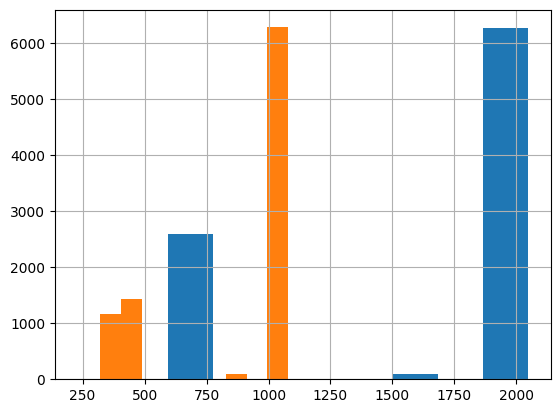

In [11]:
#width and height
dataframes['images']['width'].hist()
dataframes['images']['height'].hist()

In [12]:
# see time distribution of images to see if there might be difference in image quality 

## Licenses

- License is same for all, so don't join on `id` to rest. 

In [13]:
print(len(dataframes['licenses']['id'].unique()))
dataframes['licenses'].head()

1


,id,name,url
0,0,FathomNet,http://fathomnet.org/fathomnet/#/license


## Annotations

- `id`: bounding boxes (23700)
- `image_id`: images (8981) can join to annotations on `annotations.image_id`
- `category_id`: classes (taxa) 79. Can join to  
- Some images have more than one bounding box (i.e. more than one taxon). 

In [14]:
num_annot = len(dataframes['annotations'])
print(f'There are {num_annot} annotations in the train dataset, and {round(num_annot/79)} observations per class')
dataframes['annotations'].head()


There are 23699 annotations in the train dataset, and 300 observations per class


,id,image_id,category_id,segmentation,area,bbox,iscrowd
0,1,1,71,[],943.0,"[491.0, 254.0, 23.0, 41.0]",0
1,2,2,8,[],71577.0,"[701.0, 505.0, 241.0, 297.0]",0
2,3,3,67,[],533148.0,"[458.0, 332.0, 924.0, 577.0]",0
3,4,4,37,[],299186.0,"[1155.0, 71.0, 659.0, 454.0]",0
4,5,4,37,[],520650.0,"[66.0, 6.0, 975.0, 534.0]",0


In [15]:
#check that category_id corresponds to number of classes - yes

print("ID:",len(dataframes['annotations']['id'].unique()))
print("Category ID:", len(dataframes['annotations']['category_id'].unique()))
print("Image ID:",len(dataframes['annotations']['image_id'].unique()))


ID: 23699
Category ID: 79
Image ID: 8980


## Categories

- Competition description: "The training set contains 79 categories of marine animals of varying taxonomic ranks (e.g., family, genus, species), wherein 300 example instances of each category are provided for training."

**Our EDA**
- Categories are taxa, ranging from class (i.e. *Gastropoda*) to order (i.e. *Zoantharia*) to species (i.e. *Abyssocucumis abyssorum*)
- Training set has 79 categories - OK

In [16]:
num_cat = len(dataframes['categories']['name'])
num_id = len(dataframes['categories']['id'])

print(f'There are {num_cat} categories (taxa) in the train dataset and {num_id} unqiue IDs. ')

dataframes['categories'].head()


There are 79 categories (taxa) in the train dataset and 79 unqiue IDs. 


,id,name,supercategory
0,1,Abyssocucumis abyssorum,
1,2,Acanthascinae,
2,3,Acanthoptilum,
3,4,Actinernus,
4,5,Actiniaria,


In [17]:
dataframes['categories']['name'].unique()

array(['Abyssocucumis abyssorum', 'Acanthascinae', 'Acanthoptilum',
       'Actinernus', 'Actiniaria', 'Actinopterygii', 'Amphipoda',
       'Apostichopus leukothele', 'Asbestopluma',
       'Asbestopluma monticola', 'Asteroidea', 'Benthocodon pedunculata',
       'Brisingida', 'Caridea', 'Ceriantharia', 'Chionoecetes tanneri',
       'Chorilia longipes', 'Corallimorphus pilatus', 'Crinoidea',
       'Delectopecten', 'Elpidia', 'Farrea', 'Florometra serratissima',
       'Funiculina', 'Gastropoda', 'Gersemia juliepackardae',
       'Heterocarpus', 'Heterochone calyx', 'Heteropolypus ritteri',
       'Hexactinellida', 'Hippasteria', 'Holothuroidea', 'Hormathiidae',
       'Isidella tentaculum', 'Isididae', 'Isosicyonis', 'Keratoisis',
       'Liponema brevicorne', 'Lithodidae', 'Mediaster aequalis',
       'Merluccius productus', 'Metridium farcimen',
       'Microstomus pacificus', 'Munidopsis', 'Munnopsidae', 'Mycale',
       'Octopus rubescens', 'Ophiacanthidae', 'Ophiuroidea',
     

In [18]:
print("There are no values in the supercategory series")
dataframes['categories']['supercategory'].unique()

There are no values in the supercategory series


array([''], dtype=object)

# Join

- Join images, annotations and categories, to check the number of images per category


In [19]:
#join id in `categories` to category_id in `annotations` and 

# result = pd.merge(pd.merge(dataframes['images'], dataframes['annotations'], on='id', how='outer'), dataframes['categories'], on='id', how='outer')
# result.head()


merge_1 = dataframes['annotations'].merge(dataframes['images'], left_on='image_id', right_on='id')
merge_2 = merge_1.merge(dataframes['categories'], left_on='category_id', right_on='id')
merge_2.head()


,id_x,image_id,category_id,segmentation,area,bbox,iscrowd,id_y,width,height,file_name,license,flickr_url,coco_url,date_captured,id,name,supercategory
0,1,1,71,[],943.0,"[491.0, 254.0, 23.0, 41.0]",0,1,720,368,67cda248-6d28-4801-9c4e-e4525189ea38.png,0,https://database.fathomnet.org/static/m3/frame...,https://database.fathomnet.org/static/m3/frame...,2008-12-19 19:46:56,71,Sebastolobus,
1,2,2,8,[],71577.0,"[701.0, 505.0, 241.0, 297.0]",0,2,1920,1080,d9b399f3-8628-4138-a339-f4520be751c5.png,0,https://database.fathomnet.org/static/m3/frame...,https://database.fathomnet.org/static/m3/frame...,2019-05-30 16:41:04,8,Apostichopus leukothele,
2,3,3,67,[],533148.0,"[458.0, 332.0, 924.0, 577.0]",0,3,1920,1080,3289c3e1-40f2-4512-992f-3fa406b50a86.png,0,https://database.fathomnet.org/static/m3/frame...,https://database.fathomnet.org/static/m3/frame...,2014-06-05 20:04:19,67,Scotoplanes,
3,4,4,37,[],299186.0,"[1155.0, 71.0, 659.0, 454.0]",0,4,1920,1080,801dc37d-1aac-49ac-9067-93ae4bb7c8b6.png,0,https://database.fathomnet.org/static/m3/frame...,https://database.fathomnet.org/static/m3/frame...,2017-12-21 15:37:28,37,Keratoisis,
4,5,4,37,[],520650.0,"[66.0, 6.0, 975.0, 534.0]",0,4,1920,1080,801dc37d-1aac-49ac-9067-93ae4bb7c8b6.png,0,https://database.fathomnet.org/static/m3/frame...,https://database.fathomnet.org/static/m3/frame...,2017-12-21 15:37:28,37,Keratoisis,


In [20]:
how_many = sum(merge_2.name.value_counts() == 300)
how_many_not = sum(merge_2.name.value_counts() == 299)

print(f'{how_many} taxa have 300 bounding boxes; {how_many_not} has 299.')

78 taxa have 300 bounding boxes; 1 has 299.
